<a href="https://colab.research.google.com/github/Dominic-byte/Team-13-Regression-Predict/blob/master/Sendy_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team 13 Sendy Logistics Challenge

## Contents (finish sections 4, 5, 6, 7, 8, 9)

1. Introduction
2. Imports
3. Definitions
4. Data cleaning and preprocessing
5. Exploratoory data analysis
6. Feature engineering and selection
7. Model building
8. Results interpretation
9. Conclusion

## 1. Introduction

**Problem Landscape**

*About Sendy:* Sendy is a platform established to enable businesses to transport goods efficently across East Africa. Sendy focuses on on building practical solutions for Africa's transportation needs, from developing apps and web solutions, to providing dedicated support for goods on the move.

*Problem* Sendy would like to be able to predict the estimated time of delivery of orders from the point of driver pickup to the point of arrival at final destination.

*Value* This will help Sendy improve customer experience by enhancing customer communication and improving service reliability. In addition, the solution will enable the realisation of cost savings through improved resource management.

*Problem Statement*: **Build** a model to predict the estimated time of delivery of orders from the **`point of driver pickup`** to the **`point of arrival at final destination`**.

## 2. Imports

Packages

In [0]:
%%capture
# Standard Imports
import numpy as np
import pandas as pd

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.preprocessing import StandardScaler

# Notebook Settings
%matplotlib inline
pd.options.display.max_columns = 60
sns.set_style("whitegrid")

Data

In [0]:
# URL to training and testing data
trurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Train.csv'
turl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Test.csv'
rurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Riders.csv'
vurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/VariableDefinitions.csv'

# Loading datasets
train_df = pd.read_csv(trurl, index_col=0)
test_df = pd.read_csv(turl, index_col=0)
riders_df = pd.read_csv(rurl)
variables = pd.read_csv(vurl, index_col=0)

## 3. Definitions

In [3]:
pd.options.display.max_colwidth = 0
variables

,Unique number identifying the order
Order No,
User Id,Unique number identifying the customer on a platform
Vehicle Type,"For this competition limited to bikes, however in practice Sendy service extends to trucks and vans"
Platform Type,"Platform used to place the order, there are 4 types"
Personal or Business,Customer type
Placement - Day of Month,Placement - Day of Month i.e 1-31
Placement - Weekday (Mo = 1),Placement - Weekday (Monday = 1)
Placement - Time,Placement - Time - Time of day the order was placed
Confirmation - Day of Month,Confirmation - Day of Month i.e 1-31
Confirmation - Weekday (Mo = 1),Confirmation - Weekday (Monday = 1)


In [0]:
pd.options.display.max_colwidth = 50

In [0]:
def col_rename(df):
  """Function that renames columns and drops columns that 
  were not used in the test set
  Parameters
  ----------
  df: DataFrame
          input df to rename columns for
  Returns
  -------
  new_df: DataFrame
          output df with renamed and dropped columns
          as well as a printout of dropped columns
  """
  static_dict = {"Order No":"Order No","User Id":"User Id","Vehicle Type":"Vehicle Type","Platform Type":"Platform",
        "Personal or Business":"Pers Business","Placement - Day of Month":"Place DoM",
        "Placement - Weekday (Mo = 1)":"Place Weekday","Placement - Time":"Place Time",
        "Confirmation - Day of Month":"Confirm DoM","Confirmation - Weekday (Mo = 1)":"Confirm Weekday",
        "Confirmation - Time":"Confirm Time","Arrival at Pickup - Day of Month":"Arr Pickup DoM",
        "Arrival at Pickup - Weekday (Mo = 1)":"Arr Pickup Weekday","Arrival at Pickup - Time":"Arr Pickup Time",
        "Pickup - Day of Month":"Pickup DoM","Pickup - Weekday (Mo = 1)":"Pickup Weekday","Pickup - Time":"Pickup Time",
        "Distance (KM)":"Distance KM","Temperature":"Temperature","Precipitation in millimeters":"Precipitation mm",
        "Pickup Lat":"Pickup Lat","Pickup Long":"Pickup Long","Destination Lat":"Destination Lat","Time from Pickup to Arrival":"Time from Pickup to Arrival",
        "Destination Long":"Destination Long","Rider Id":"Rider Id"}
  new_df = df.copy()
  new_cols = {}
  droplist = []
  for col in new_df.columns:
    if col in static_dict.keys():
      new_cols[col] = static_dict[col].replace(" ","_")
    else:
      droplist.append(col)
  new_df.rename(columns = new_cols, inplace=True)
  for col in droplist:
    if col in new_df.index:
      return new_df.drop(columns=droplist, inplace=True)
  return new_df

In [0]:
atrain_df  = col_rename(train_df)
atest_df =  col_rename(test_df)
ariders_df = col_rename(riders_df)

In [7]:
for col in atrain_df.columns:
    if col not in atest_df.columns and col != 'Time_from_Pickup_to_Arrival':
        print(col)
        atrain_df.drop(columns=col, inplace = True)

Arrival at Destination - Day of Month
Arrival at Destination - Weekday (Mo = 1)
Arrival at Destination - Time


In [8]:
# Storing variable names and test index
train_columns = atrain_df.columns
test_columns = atest_df.columns
riders_columns = ariders_df.columns
test_index = atest_df.index
target = train_columns[-1]

# Inspect data
print(train_df.shape, test_df.shape, riders_df.shape)
train_df.head(3)
print(target)

(21201, 28) (7068, 24) (960, 5)
Time_from_Pickup_to_Arrival


## 4. Data cleaning and preprocessing (BBP)

In [9]:
pd.merge(atrain_df, ariders_df, how='left', on='Rider_Id').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   User_Id                      21201 non-null  object 
 1   Vehicle_Type                 21201 non-null  object 
 2   Platform                     21201 non-null  int64  
 3   Pers_Business                21201 non-null  object 
 4   Place_DoM                    21201 non-null  int64  
 5   Place_Weekday                21201 non-null  int64  
 6   Place_Time                   21201 non-null  object 
 7   Confirm_DoM                  21201 non-null  int64  
 8   Confirm_Weekday              21201 non-null  int64  
 9   Confirm_Time                 21201 non-null  object 
 10  Arr_Pickup_DoM               21201 non-null  int64  
 11  Arr_Pickup_Weekday           21201 non-null  int64  
 12  Arr_Pickup_Time              21201 non-null  object 
 13  Pickup_DoM      

### a. Data types

**Numerical**
- Ratio
  - *Number of Orders*
  - *Age*
  - *Number of Ratings*
  - *Time from pickup to arrival* - Target
  - *Geospatial Distance*`
- Interval
  - *Time (Placement, Confimation, Arrival, etc)* 
  - *Distance (KM)*
  - *Temperature*
  - *Precipitation*
  - *Co-ordinates*

**Categorical**
- Nominal
  - *User Id*
    - This is categorical as it only varies in the user that has\
      placed the order.
    - It may be possible to determine the frequency of orders\
      placed by customers and determine their loyalty. This may\
      reflect a drivers motivation to provide higher quality\
      service to that user.
  - *Vehicle Type*
    - The type of vehicle used would ordinarily have an impact on\
      delivery time as a motorcycle would be faster than a truck.
    - Since there is only one vehicle type to consider (bike)\
      there is no value to be gained from this data
  - *Platform Type*
    - The source of order placement is qualitative and may give\
      information about the level of service delivery for the\
      various platforms. More frequently used platforms may be\
      serviced better by drivers as they may provide a steady\
      stream of customers.
    - The platform can only take on the values from 1 to 4 and\
      should be stored as an `int16`
  - *Personal or Business*
    - Business orders are likely to be frequent and and located\
      near central business district, whereas personal orders\
      may require further travel to suburban areas. This could\
      have an effect on the travel time.
  - *Day of month (Placement, Confimation, Arrival, etc)*
    - The day of month can only vary in its quality. There may\
      more or less orders placed on a given day of the month.\
    - Since the values of day of month can take on values between\
      1 and 31 it would be most effecient to store it as an `int16`\
      instead of `int64` which is for larger numbers.
    - It may be that more orders are placed on certain days that\
      would result in longer delivery times.    
  - *Weekday*
    - Businesses typically operate on weekdays. It would logically\
      follow that weekdays are busier than weekends resulting in\
      longer delivery times due  to traffic or the volume of\
      orders.
    - Since the weekday is represented by 1 to 7, it should be\
      stored as an `int16`
    - *Rider Id*

- Ordinal
  - *Average rating*
    - Drivers are usually rated on a scale from one to 5. As a driver\
      recieves more ratings, the will begin to settle around their\
      true score. This score could reflect the driver's performance\
      with respect to timeliness.

### b. Cleaning functions

In [0]:
def data_preprocessing(df):
  """Function that preprocesses data used for predictions and testing
  Parameters
  ----------
  df: DataFrame
          DataFrame to preprocess.
  Returns
  -------
  df: DataFrame
          Preprocessed DataFrame

  """
  cdf = df.copy()
  old = cdf.memory_usage().sum()
  # Create lists of columns to change
  integers = [col for col in cdf.columns if cdf[col].dtypes == 'int64']
  floats = [col for col in cdf.columns if cdf[col].dtypes == 'float64']
  time_cols = [col for col in cdf.columns if col.endswith("Time")]

  # Reduce size of data storage types
  cdf[integers] = cdf[integers].astype('int16')
  cdf[floats] = cdf[floats].astype('float16')
  for col in time_cols:
    cdf[col] = pd.to_datetime(cdf[col]).dt.time
  
  # Correcting specific columns
  if 'Distance (KM)' in cdf.columns:
    cdf['Distance (KM)'] = cdf['Distance (KM)'].astype('float16') 

  new = cdf.memory_usage().sum()
  print("Bytes\t","\nOld:\t", str(old), "\nNew:\t", "("+str(new)+")", "\nSaved:\t", str(old - new))
  return cdf

In [0]:
%%capture [--no-display]
# Store transformations in EDA DataFrame
eda_df, eda_test, eda_riders = data_preprocessing(atrain_df), data_preprocessing(atest_df), data_preprocessing(ariders_df)

## 5. Data Exploration and preparation

### a. Exploratory data analysis


#### 1. Target - Time from Pickup to Arrival

In [12]:
# Confirming the caluclation of the Target

Target = pd.to_datetime(train_df['Arrival at Destination - Time']) - pd.to_datetime(train_df['Pickup - Time'])
list(Target.dt.seconds[:]) == list(atrain_df[target][:])

True

In [13]:
eda_df[target].describe()

count    21201.000000
mean      1556.920947
std        987.270788
min          1.000000
25%        882.000000
50%       1369.000000
75%       2040.000000
max       7883.000000
Name: Time_from_Pickup_to_Arrival, dtype: float64

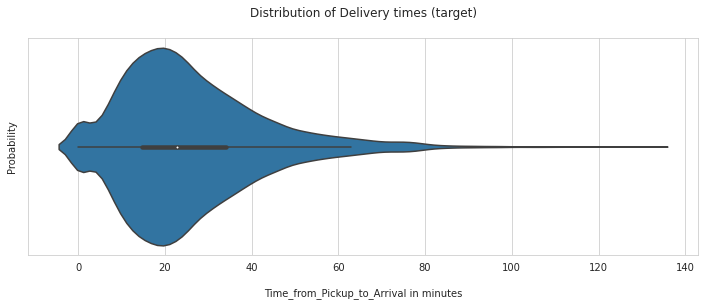

In [14]:
# Histogram
fig = plt.figure(figsize=(12,4))
sns.violinplot(eda_df[target]/60)
plt.title('Distribution of Delivery times (target)\n')
plt.xlabel('\n'+target+' in minutes')
plt.ylabel("Probability")
plt.show()

#### 2. Univariate analysis (D)

2.1 Numerical

In [15]:
#Analysing the features based on one variable type
col_numerical = [col for col in eda_df.columns if eda_df[col].dtypes != 'object' and col !=target]
eda_df[col_numerical].describe()

,Platform,Place_DoM,Place_Weekday,Confirm_DoM,Confirm_Weekday,Arr_Pickup_DoM,Arr_Pickup_Weekday,Pickup_DoM,Pickup_Weekday,Distance_KM,Temperature,Precipitation_mm,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,1.683500e+04,552.000000,21201.000000,2.120100e+04,21201.000000,2.120100e+04
mean,2.752182,15.653696,3.240083,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,9.506533,inf,7.906250,-1.281250,inf,-1.282227,inf
std,0.625178,8.798916,1.567295,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,5.668963,3.617188e+00,17.093750,0.030548,3.918457e-02,0.034851,4.562378e-02
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.120312e+01,0.099976,-1.438477,3.665625e+01,-1.430664,3.659375e+01
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,2.059375e+01,1.074219,-1.300781,3.678125e+01,-1.300781,3.678125e+01
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,2.350000e+01,2.900391,-1.279297,3.681250e+01,-1.284180,3.681250e+01
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,2.600000e+01,4.898438,-1.256836,3.684375e+01,-1.260742,3.684375e+01
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,49.000000,3.209375e+01,99.125000,-1.147461,3.700000e+01,-1.030273,3.703125e+01


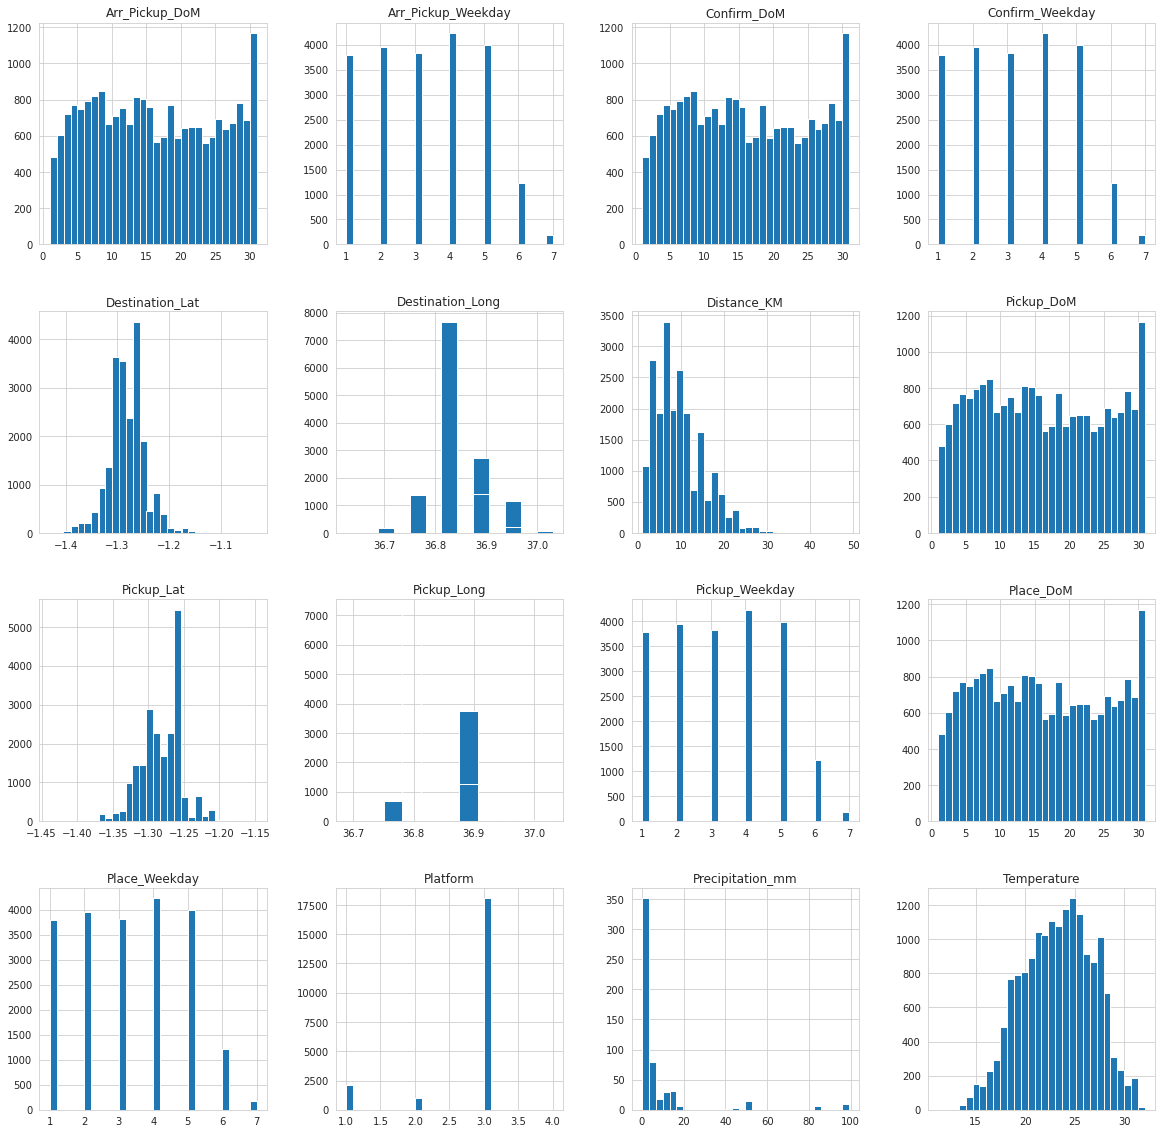

In [16]:
#Plot histogram of numerical values
def histogram_plot(df,cols,bins = 10):

  """Function creates histogram of all numerical columns
  Parameters
  ----------
  df: DataFrame
          DataFrame to preprocess.
  cols: list
          list of numerical columns or object columns
  bins: string
          number of bins you want histogram to create
  Returns
  -------
  {Plot}: Returns plot of column histograms for analysis
          
  """
  df[cols].hist(bins = bins, figsize  = (20,20))
  return plt.show()
histogram_plot(eda_df,col_numerical,30)

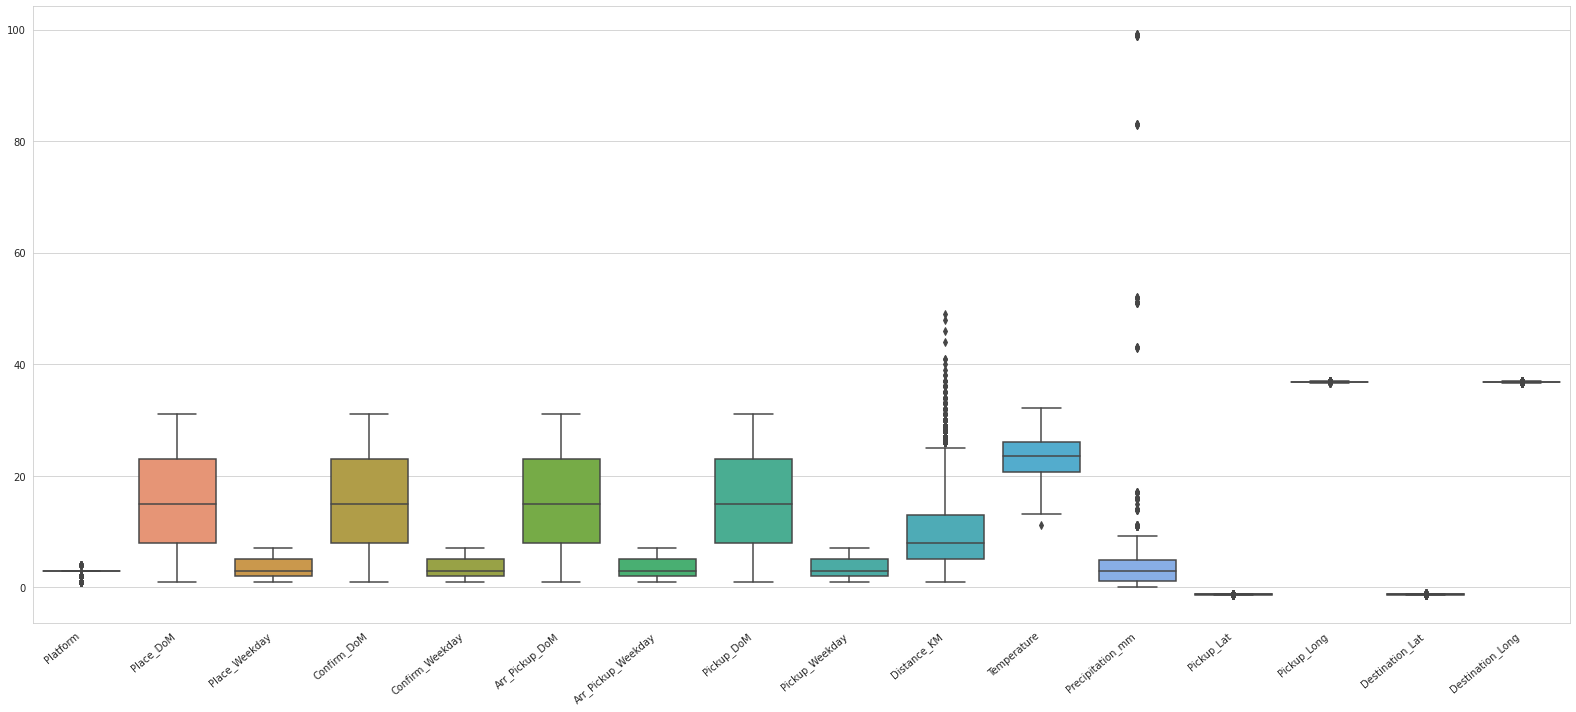

In [17]:
#Plot Boxplot of graphs
def box_plot(df,cols):
  """Function creates histogram of all numerical columns
  Parameters
  ----------
  df: DataFrame
          DataFrame to preprocess.
  cols: list
          list of numerical columns
  Returns
  -------
  {Plot}: Returns plot of boxplot for dataframe
          
  """
  plt.figure(figsize=(22,10))
  ax = sns.boxplot(data = df[cols])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  plt.tight_layout()
  return plt.show()
box_plot(eda_df,col_numerical)

**Analysis:** **Histogram**

From the individual numerical data plots, You can see that all the weekday varaibles follow uniform distribution except for Saturday and Sunday. Those appear to be very low compared to deliveries in the week.  

All data for days of the month follow a multimodal distribution and the peaks vary throughout the month, but day 30 seems to have an exceedingly high peak compared to the rest of the days. 

Destination lat and long show normal distribution with most of the deliveries going to approximately (-1.28,36.85)

Pickup lat follows a normal distribution with a peak of (-1.27) and Pickup long shows a skewed left distribution which means most of the observations are happening around coordinate (36.9). Approximately between these two coordinates seem to be where most of the pickups happen.

The platform type distribution is left skewed showing that most of the deliveries by a substantial amount happen on platform 3. 

Temperature follows a normal distribution with the peak being 23.5. Distance and precipitation show a skewed right distribution with most of the kilometres ranging between 0-15km and most precipitation ranging from 0-5mm of rain.

**Analysis:** **Boxplot**

From looking at the box plot, all numerical values range differently from the plot above therefore might have to do some standardisation/normalisation for the models that depend on scaling for accuracy, the GPS range is very small since a changing the decimal coordinates slightly takes you to a new area. The distance and precipitation show outliers that may affect our results so we need to pay close attention to these two variables.



2.2 Objects

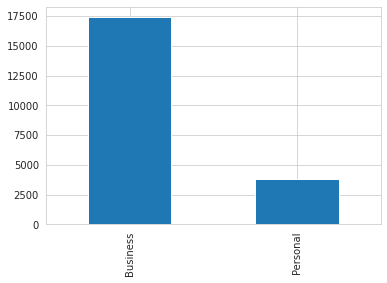

In [18]:
# Number of orders of personal or business
eda_df['Pers_Business'].value_counts().plot(kind='bar')

**Analysis on histogram plot for object type**

From looking at the results, it shows that mainly businesses used their delivery platforms to order.

#### 3. Bivariate analysis (AB)

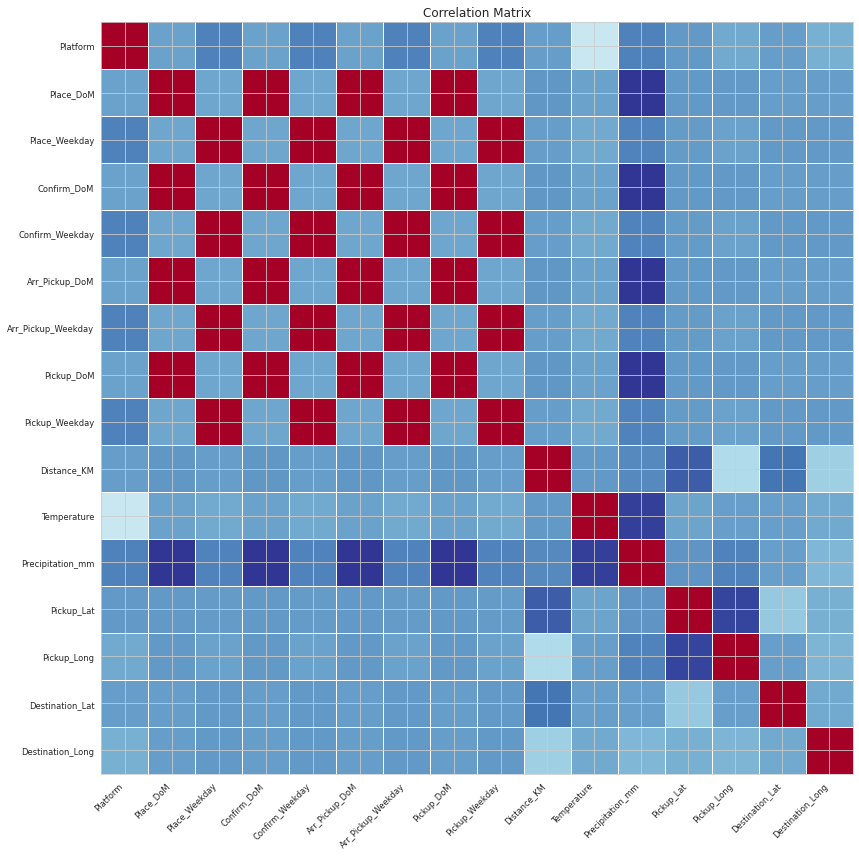

In [19]:
corr= eda_df.drop(target, axis='columns').corr()
from statsmodels.graphics.correlation import plot_corr

fig = plt.figure(figsize=(12,12));
ax = fig.add_subplot(111);
plot_corr(corr, xnames = corr.columns, ax = ax);

From the above correlation matrix some features are strongly postively and negatively correlated, suggesting that these features may lead to an increased standard error as well as a difficulty to determine the effect of any one predictor variable on the response variable. This could lead to the removal of some if not all of these features.

#### 4. Remove Collinearity


In [0]:
def collinear(df):
  """Function that drops chosen columns
  Parameters
  ----------
  df: DataFrame
          DataFrame to drop columns from
  cols: list-like
          Names of columns to be dropped from
  Returns
  -------
  col_df: DataFrame
          Modified DataFrame
  """
  col_df = df.copy()
  droplist = ['Place_DoM', 'Place_Weekday',
              'Place_Time', 'Confirm_DoM', 
              'Confirm_Weekday', 'Confirm_Time',
              'Arr_Pickup_DoM', 'Arr_Pickup_Weekday',
              'Arr_Pickup_Time']
  if droplist[0] in col_df.columns:
    col_df = col_df.drop(columns=droplist)
  
  return col_df


In [0]:
btrain = collinear(eda_df)
btest = collinear(eda_test)
briders = collinear(eda_riders) 

6. Missing values treatment (HELPER FUNCTIONS)

In [0]:
def null(df, na_thresh = 1.0 , strategy = "median"):
  """Function that drops columns with more than na_thresh null from
  
  """
  no_null=df.copy()
  # Dropping NaN's
  for col in no_null.columns:
    missing = no_null[col].isnull().sum()/len(no_null)
    if missing > na_thresh:
      no_null.drop(columns=col, inplace=True)
    
  # Filling NaN's
  for col in no_null.columns:
    if no_null[col].isnull().sum() > 0:
      if no_null[col].dtypes == 'object':
        no_null[col].fillna(no_null[col].mode(), inplace=True) 
      elif strategy == 'mean':
        no_null[col].fillna(round(no_null[col].mean()), inplace=True)
      elif strategy == 'median':
        no_null[col].fillna(round(no_null[col].median()), inplace=True)
      elif strategy == 'rolling':
        no_null[col].fillna(no_null[col].rolling(7).mean(), inplace=True)
      else:
        raise ValueError
  return no_null

In [0]:
ctrain = null(btrain)
ctest = null(btest)
criders = null(briders)

b. Feature engineering and selection (B)


1. Variable transformation

In [26]:
pd.merge(ctrain, criders, how='left', on='Rider_Id').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   User_Id                      21201 non-null  object 
 1   Vehicle_Type                 21201 non-null  object 
 2   Platform                     21201 non-null  int16  
 3   Pers_Business                21201 non-null  object 
 4   Pickup_DoM                   21201 non-null  int16  
 5   Pickup_Weekday               21201 non-null  int16  
 6   Pickup_Time                  21201 non-null  object 
 7   Distance_KM                  21201 non-null  int16  
 8   Temperature                  21201 non-null  float16
 9   Precipitation_mm             21201 non-null  float16
 10  Pickup_Lat                   21201 non-null  float16
 11  Pickup_Long                  21201 non-null  float16
 12  Destination_Lat              21201 non-null  float16
 13  Destination_Long

2. Variable creation

### 6. Model building

## 6. Results interpretation

## 7. Conclusion